## Detecting Depression using TF-IDF and BoW Methods

In [ ]:
## Checking the Dataset

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')
#open('sentiment_tweets3.csv').read()

tweets = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/sentiment_tweets3.csv")
tweets.head(20)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


The Dataset has 3 columns now. The first **Unnamed Column** is not useful to do any analysis. The second column is any **message** ever tweeted and third column is the **label** marker for each Tweet. If the Tweet was indicating signs of depression then it is 1 and if not then it is 0. 

*Removing the First column.....*

In [ ]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


## Splitting into Test and Train Data

95% of the Dataset is used in Training. Rest will be used for Testing.

In [ ]:
trainId, testId = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.95:
        trainId += [i]
    else:
        testId += [i]
trainData = tweets.iloc[trainId]
testData = tweets.iloc[testId]

In [ ]:
print("Number of Depressive Tweets in Training set is {}".format(trainData['label'].value_counts()[0]))
print("Number of Non-Depressive Tweets in Training set is {} \n".format(trainData['label'].value_counts()[1]))
print("Number of Depressive Tweets in Test set is {}".format(testData['label'].value_counts()[0]))
print("Number of Non-Depressive Tweets in Test set is {}".format(testData['label'].value_counts()[1]))

Number of Depressive Tweets in Training set is 7612
Number of Non-Depressive Tweets in Training set is 2201 

Number of Depressive Tweets in Test set is 388
Number of Non-Depressive Tweets in Test set is 113


The above values give the number of Depressive and non depressive Tweets in the split dataset.

## Wordcloud Analysis

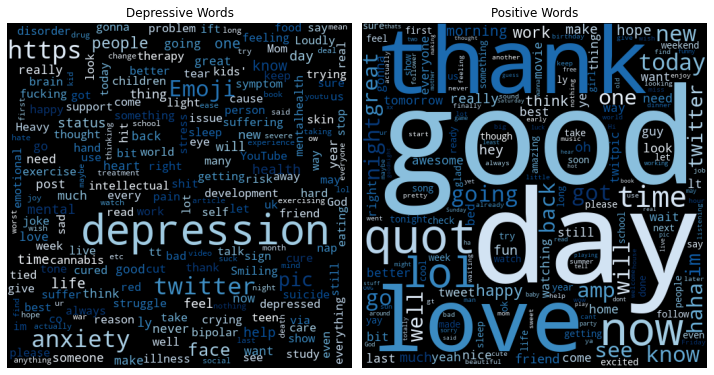

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

def wordc(k):
    words = ' '.join(list(tweets[tweets['label'] == k]['message']))
    wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(words)
    return(wc)

fig , (ax1, ax2) = plt.subplots(1,2 , figsize = (10, 8) )
ax1.imshow(wordc(1))
ax1.set_title("Depressive Words")
ax2.imshow(wordc(0))
ax2.set_title("Positive Words")
ax1.axis('off')
ax2.axis('off')
plt.tight_layout(pad = 1)
plt.show()

## Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from math import log, sqrt
import re

def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
        
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
        
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]  
        
    return words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class TweetClassifier(object):
    
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1
    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return(pDepressive >= pPositive)

    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [ ]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
        

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [ ]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.864406779661017
Recall:  0.45132743362831856
F-score:  0.5930232558139535
Accuracy:  0.8602794411177644


In [ ]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.9117647058823529
Recall:  0.2743362831858407
F-score:  0.42176870748299317
Accuracy:  0.8303393213572854


In [ ]:
tweet = process_message('Extreme sadness')
print(sc_tf_idf.classify(tweet))
print(sc_bow.classify(tweet))

True
True
